# Project M9: Exoplanet detection using the transit method

Marko Raidlo, Raidlo Everest

In [4]:
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
#plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 30})


import numpy as np
import pandas as pd
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## Loading in the datasets

In [2]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')
    
train.columns = [train.columns[i].replace("FLUX.", "") for i in range(len(train.columns))]
test.columns = [test.columns[i].replace("FLUX.", "") for i in range(len(test.columns))]
    
#Replacing 2s and 1s with 1s and 0s.
train.LABEL = train.LABEL.replace(1, 0)
train.LABEL = train.LABEL.replace(2, 1)
test.LABEL = test.LABEL.replace(1, 0)
test.LABEL = test.LABEL.replace(2, 1)
    
#X and Y datasets
train_X = train.drop('LABEL', axis=1)
train_Y = train["LABEL"]

test_X = test.drop('LABEL', axis=1)
test_Y = test["LABEL"]

train_X.head()

,1,2,3,4,5,6,7,8,9,10,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Preprocessing

In [3]:
def fourier(df):
        return np.abs(fft(df, n=df.size))

def pre_process(df):
    #Preprocessing method applies:
    # Fourier transform
    # Normalization
    # Gaussian filter
    # Standardization
    
    #Fourier
    df_copy = df.copy()
    df_copy = df_copy.apply(fourier ,axis=1)
    
    df_copy = pd.DataFrame(df_copy.tolist())
    df_copy  = df_copy.iloc[:,0:df_copy.shape[1]//2]
    
    # Normalize
    df_copy = pd.DataFrame(normalize(df_copy))

    # Gaussian filter to smooth out data
    df_copy = ndimage.filters.gaussian_filter(df_copy, sigma=10)

    # Standardize X data
    std_scaler = StandardScaler()
    df_copy = std_scaler.fit_transform(df_copy)
    
    return pd.DataFrame(df_copy)

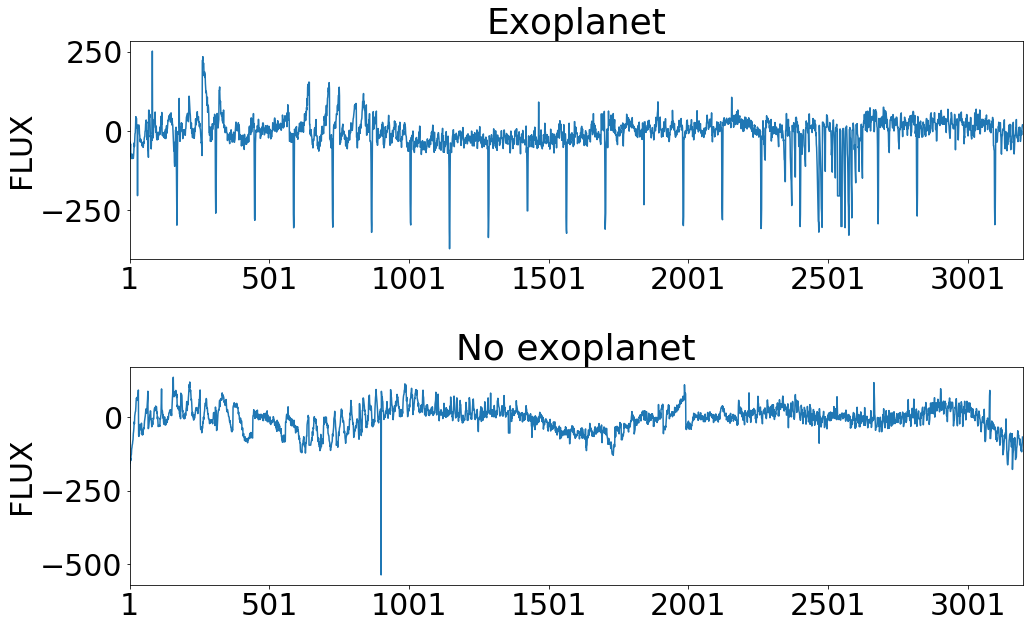

In [5]:
#Pre process plot

plt.subplot(211)
plt.title("Exoplanet")
train_X.iloc[1].plot()
plt.ylabel("FLUX")
plt.subplot(212)
plt.title("No exoplanet")
train_X.iloc[3213].plot()
plt.ylabel("FLUX")

plt.subplots_adjust(hspace=0.5)
#plt.savefig('fig1.png', dpi = 1000)
plt.show()

In [6]:
# Processing data
train_X = pre_process(train_X)
test_X = pre_process(test_X)

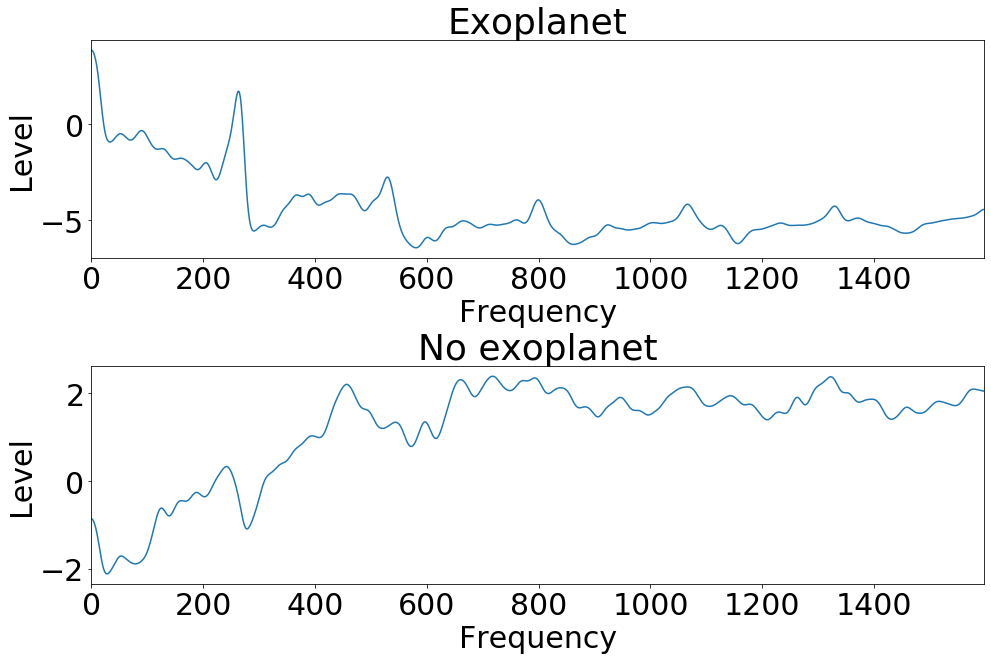

In [7]:
#Post process plot

plt.subplot(211)
plt.title("Exoplanet")
train_X.iloc[1].plot()
plt.ylabel("Level")
plt.xlabel("Frequency")
plt.subplot(212)
plt.title("No exoplanet")
train_X.iloc[3213].plot()
plt.ylabel("Level")
plt.xlabel("Frequency")

plt.subplots_adjust(hspace=0.5)
#plt.savefig('fig2.png', dpi = 1000)
plt.show()

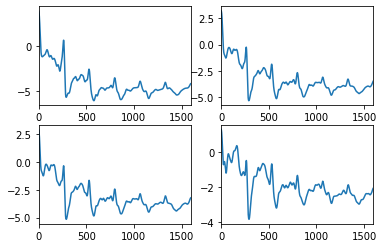

In [7]:
# Exoplanet star results
plt.subplot(221)
train_X.iloc[12].plot()
plt.subplot(222)
train_X.iloc[21].plot()
plt.subplot(223)
train_X.iloc[23].plot()
plt.subplot(224)
train_X.iloc[32].plot()


plt.show()

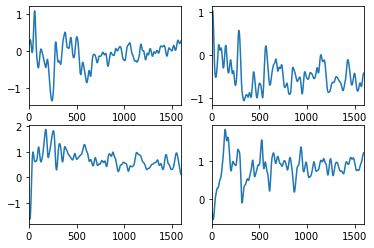

In [8]:
# Non exoplanet star results
plt.subplot(221)
train_X.iloc[1111].plot()
plt.subplot(222)
train_X.iloc[2231].plot()
plt.subplot(223)
train_X.iloc[4512].plot()
plt.subplot(224)
train_X.iloc[1233].plot()

plt.show()

## Building models

In [10]:
#Evaluation method:

def evaluate(model):
    train_result =  model.predict(train_X)
    test_result = model.predict(test_X)
    confm_train = confusion_matrix(train_Y, train_result)
    confm_test = confusion_matrix(test_Y, test_result)
    
    acc_train = accuracy_score(train_Y, train_result)
    acc_test = accuracy_score(test_Y, test_result)
    pre_train = precision_score(train_Y, train_result)
    pre_test = precision_score(test_Y, test_result)
    rec_train = recall_score(train_Y, train_result)
    rec_test = recall_score(test_Y, test_result)
    auc_train = roc_auc_score(train_Y, train_result)
    auc_test = roc_auc_score(test_Y, test_result)
    
    print("------------------Evaluation------------------")
    print("On training set:")
    print("Accuracy:", acc_train)
    print("Precision:", pre_train)
    print("Recall:", rec_train)
    print("AUC score:", auc_train)
    print("Confusion matrix:")
    print(confm_train)
    print("----------------------------------------------")
    print("On test set:")
    print("Accuracy:", acc_test)
    print("Precision:", pre_test)
    print("Recall:", rec_test)
    print("AUC score:", auc_test)
    print("Confusion matrix:")
    print(confm_test)
    print("--------------End of valuation----------------")

### Logistic Regression

In [11]:
model_log = LogisticRegression()
model_log.fit(train_X, train_Y)

evaluate(model_log)

C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9912280701754386
Precision: 0.5
Recall: 1.0
AUC score: 0.995575221238938
Confusion matrix:
[[560   5]
 [  0   5]]
--------------End of valuation----------------


### Support Vector Machine

In [12]:
model_svm = svm.LinearSVC()
model_svm.fit(train_X, train_Y)
evaluate(model_svm)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9842105263157894
Precision: 0.35714285714285715
Recall: 1.0
AUC score: 0.9920353982300886
Confusion matrix:
[[556   9]
 [  0   5]]
--------------End of valuation----------------


C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### K Nearest Neighbours

In [13]:
model_knn = KNeighborsClassifier(n_neighbors = 9, weights = 'distance')
model_knn.fit(train_X, train_Y)

evaluate(model_knn)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9912280701754386
Precision: 0.0
Recall: 0.0
AUC score: 0.5
Confusion matrix:
[[565   0]
 [  5   0]]
--------------End of valuation----------------


C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision tree

In [14]:
model_tree = DecisionTreeClassifier()
model_tree.fit(train_X, train_Y)

evaluate(model_tree)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9982456140350877
Precision: 0.8333333333333334
Recall: 1.0
AUC score: 0.9991150442477876
Confusion matrix:
[[564   1]
 [  0   5]]
--------------End of valuation----------------


### Random forest

In [15]:
model_forest = RandomForestClassifier(n_estimators=5, max_depth=3, random_state=3)
model_forest.fit(train_X, train_Y)

evaluate(model_forest)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[565   0]
 [  0   5]]
--------------End of valuation----------------


### Clustering

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=2, random_state=0).fit(train_X, train_Y)

evaluate(clf)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9982456140350877
Precision: 1.0
Recall: 0.8
AUC score: 0.9
Confusion matrix:
[[565   0]
 [  1   4]]
--------------End of valuation----------------


### Neural networks

In [17]:
#Maybe tensorflow??

## Output for poster

In [18]:

#plt.savefig('yourfilename.pdf')